In [1]:
# from openai import OpenAI

# client = OpenAI(
#     base_url="https://lzl4i1wx0cdh9a-8000.proxy.runpod.net/v1",
#     api_key=""
# )

# resp = client.chat.completions.create(
#     model="llama4scout",
#     messages=[
#         {"role": "system", "content": "You are a concise assistant."},
#         {"role": "user", "content": "Привет! Что такое LLM? Кратко."}
#     ],
#     temperature=0.2,
# )
# print(resp.choices[0].message.content)

In [2]:
from IPython.display import Image, display

import app.agent as agent

In [3]:
graph = agent.build_agent_with_router()

In [ ]:
# display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
from app.agent import AgentState
from langchain_core.messages import (
    HumanMessage,
)

In [ ]:
# user_q = "топ-5 продуктов (наименования) по продажам в тенге за последние 30 дней"

# init_state: AgentState = {
#     "messages": [HumanMessage(user_q)],
#     "next_tool": None,
#     "tool_args": None,
#     "final_answer_ready": False,
# }

config = {"configurable": {"thread_id": "user_123"}}
msg = {"messages": [{"role": "user", "content": "топ-5 продуктов (наименования) по продажам в тенге за последние 30 дней"}]}

out = graph.invoke(msg, config=config)

In [ ]:
print(out['messages'][-1].content)

In [ ]:
config = {"configurable": {"thread_id": "user_123"}}
msg = {"messages": [{"role": "user", "content": "Дай график"}]}

out = graph.invoke(msg, config=config)

In [ ]:
print(out['messages'][-1].content)

In [ ]:
config = {"configurable": {"thread_id": "user_123"}}
msg = {"messages": [{"role": "user", "content": "Дай график подневных продаж за последние 30 дней"}]}

out = graph.invoke(msg, config=config)

In [ ]:
print(out['messages'][-1].content)

In [3]:
from darts.models import TBATS

In [1]:
import app.tools as tools

/Users/aziz/Documents/repos/shai-hackathon/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
connt = tools.get_db_conn()

In [52]:
sql = "SELECT order_date date, sales_tg FROM fact_sales WHERE sku_id = 60140 AND store_id = 401 AND order_date >= '2025-01-01' AND order_date < '2025-12-31'"

In [53]:
import pandas as pd
df = pd.read_sql_query(sql, connt)

In [54]:
df.head()

,date,sales_tg
0,2025-01-22 00:00:00,632.06
1,2025-01-22 00:00:00,848.98
2,2025-01-28 00:00:00,748.74
3,2025-01-28 00:00:00,411.40
4,2025-01-09 00:00:00,320.14


In [102]:
from darts import TimeSeries
col_name = 'sales_tg'
horizon = 14

from darts.models import ARIMA, ExponentialSmoothing

df = df.groupby(['date'], as_index=False).agg({f'{col_name}': 'sum'}).sort_values(by='date')
df['date'] = pd.to_datetime(df['date'])
series = TimeSeries.from_dataframe(
    df, time_col="date", value_cols=col_name, freq="D"
    )

model = ExponentialSmoothing()
model.fit(series)

forecast = pd.DataFrame({"date": pd.date_range(
    df["date"].max() + pd.Timedelta(days=1),
    periods=horizon,
    freq="D"
)})
forecast[col_name] = model.predict(horizon).values().flatten()
res = pd.concat([df, forecast])


In [97]:
df

,date,sales_tg
0,2025-01-01,42308.90
1,2025-01-02,77048.48
2,2025-01-03,135978.75
3,2025-01-04,126622.84
4,2025-01-05,115912.52
...,...,...
252,2025-09-10,183799.36
253,2025-09-11,189851.74
254,2025-09-12,207326.32
255,2025-09-13,267444.74


In [ ]:
# metric = 'sales_tg'
# HORIZON_DAYS = 30

# series = TimeSeries.from_dataframe(
#     df, time_col="date", value_cols=metric, freq="D"
# )

# # model = TBATS(use_trend=True, season_length=[7, 365])
# # model = ARIMA(p=1, d=1, q=1)
# # model = AutoARIMA(start_p=1, start_q=1, max_p=5, max_q=5, seasonal=True)
# model = ExponentialSmoothing(seasonal="additive", seasonal_periods=7)

# model.fit(series)

# forecast = model.predict(HORIZON_DAYS)

AttributeError: 'str' object has no attribute 'value'

In [85]:
df["date"] = pd.to_datetime(df["date"])

res = pd.DataFrame({"date": pd.date_range(
        df["date"].max() + pd.Timedelta(days=1),
        periods=HORIZON_DAYS,
        freq="D"
    )})

res['sales_tg'] = forecast.values().flatten()

In [86]:
res = pd.concat([df, res])

In [87]:
df['date'].max()

Timestamp('2025-09-14 00:00:00')

In [88]:
%matplotlib inline

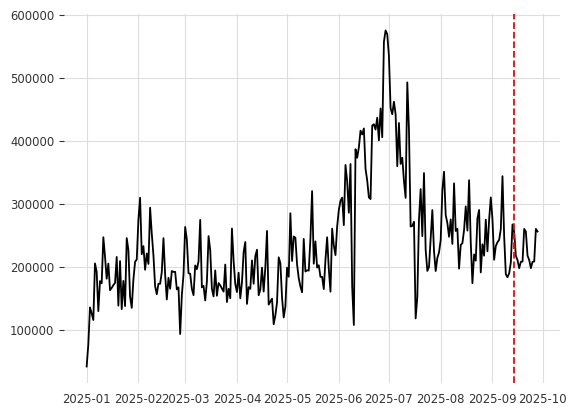

In [103]:
import matplotlib.pyplot as plt

plt.plot(res['date'], res['sales_tg'])
plt.axvline(x=df['date'].max(), color="red", linestyle="--")
# plt.ylabel('sales_tg')
# plt.title('Sales')
# plt.xticks(rotation=45, ha="right")

plt.show()

In [63]:
forecast

<TimeSeries (date: 30, component: 1, sample: 1)> Size: 240B
array([[[ 2.20015648e+05]],

       [[ 1.87410763e+05]],

       [[ 1.53484209e+05]],

       [[ 7.12764033e+04]],

       [[-5.67266620e+04]],

       [[-2.57560422e+05]],

       [[-6.36434856e+05]],

       [[-1.25661635e+06]],

       [[-2.12759746e+06]],

       [[-3.33262130e+06]],

...

       [[-8.68164674e+07]],

       [[-1.07386769e+08]],

       [[-1.31572097e+08]],

       [[-1.59783322e+08]],

       [[-1.92476078e+08]],

       [[-2.30056071e+08]],

       [[-2.72950852e+08]],

       [[-3.21650574e+08]],

       [[-3.76579412e+08]],

       [[-4.38074823e+08]]])
Coordinates:
  * date       (date) datetime64[ns] 240B 2025-09-15 2025-09-16 ... 2025-10-14
  * component  (component) object 8B 'sales_tg'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [7]:
config = {"configurable": {"thread_id": "user_122"}}
msg = {"messages": [{"role": "user", "content": "Покажи топ-3 продукта по выручке продаж за последнюю неделю"}]}

out = graph.invoke(msg, config=config)
print(out['messages'][-1].content)

 - TOOL CALL: get_current_date()
 - TOOL CALL: list_tables()
 - TOOL CALL: describe_table(fact_sales)
 - TOOL CALL: execute_query(SELECT sku_id, SUM(sales_tg) as total_sales FROM fact_sales WHERE order_date >= date('now', '-7 days') GROUP BY sku_id ORDER BY total_sales DESC LIMIT 3)
{"name": "execute_query", "parameters": {"sql": "SELECT name FROM dict_sku WHERE id IN (60140, 45180, 265730)"}}


In [6]:
print(out['messages'][-1].content)

{"name": "execute_query", "parameters": {"sql": "SELECT name FROM dict_sku WHERE id IN (60140, 45180, 265730)"}}
